<a href="https://colab.research.google.com/github/vahadruya/Capstone-Project-Unsupervised-ML-Topic-Modelling/blob/main/Intermediate_Colab_Notebooks/Unsupervised_ML_Capstone_Day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Day 1 - A Rough modeling of the data using LDA. Pre-proecssing of the text included: 
*   Removing punctuations
*   Removing stopwords
*   Stemming

Tokenisation using CountVectorizer

**pyLDAvis is recently incompatible with the updated attribute of sklearn get_feature_names_out() instead of get_feature_names. I have updated this in the sklearn.py file of pyLDAvis.sklearn.prepare locally to deal with the issue**

In [ ]:
import pandas as pd
import numpy as np
import glob
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.set_option('display.max_colwidth', None)

## 1. Reading the Data

In [ ]:
# Function for organising one article into 'Title' and 'Description' Columns
def organise_data(df):
  df['Description'] = ''
  for row in df[df.columns.values[0]]:
    df['Description'] += ' ' + row
  df['Title'] = df.columns.values[0]
  df = pd.DataFrame(df[['Title', 'Description']].loc[0]).transpose()
  return df

# Function for reading files from one particular category
def read_from_folder(category, path):
  files = glob.glob(path + category + "/*.txt")
  df = pd.DataFrame(pd.read_table(files[0]))
  df = organise_data(df)
  
  # Reading the rest of the files in the category, assigning a column for the given category name, and concatenating to the above DataFrame
  for i in range(1, len(files)):
    try:
      next_df = pd.DataFrame(pd.read_table(files[i]))
    except UnicodeDecodeError:
      next_df = pd.DataFrame(pd.read_table(files[i], encoding = 'ISO-8859-1'))
    except pd.errors.ParserError:
      next_df = pd.DataFrame(pd.read_table(files[i], quoting=csv.QUOTE_NONE))
    next_df = organise_data(next_df)
    df = pd.concat([df, next_df], axis=0)
    df['Category'] = category.capitalize()
    df = df.reset_index(drop=True)
  return df

# Function for reading files from all categories and concatenating into one single DataFrame
def read_from_folders(categories, path):
  category_dict = dict()
  for category in categories:
    category_dict[category] = read_from_folder(category, path)
  final_data = pd.concat([category_dict[category] for category in categories], axis=0).reset_index(drop=True)
  return final_data

In [ ]:
path = '/content/drive/MyDrive/ALMA BETTER/Module 4/#CAPSTONE 3 - UNSUPERVISED/Data/'
folders = ['business', 'entertainment', 'politics', 'sport', 'tech']

In [ ]:
data = read_from_folders(folders, path)

In [ ]:
data.shape

(2225, 3)

In [ ]:
data.drop_duplicates(inplace=True, ignore_index = True)

In [ ]:
data.shape

(2125, 3)

In [ ]:
data['Category'].value_counts()

Business         503
Sport            503
Politics         403
Entertainment    369
Tech             347
Name: Category, dtype: int64

<AxesSubplot:>

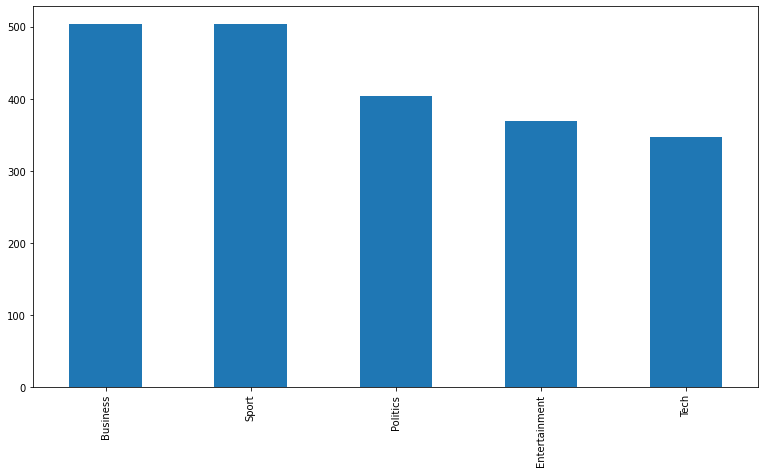

In [ ]:
data['Category'].value_counts().plot(kind='bar', figsize = (13,7))

## 2. Data Pre-Processing

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2.1 Removing Stopwords and Punctuations

In [ ]:
def remove_punc(text):
  return text.translate(text.maketrans('', '', string.punctuation))

def remove_stopwords(text, stop_words):
  text = [word.lower() for word in text.split() if word.lower() not in stop_words]
  return ' '.join(text)

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
data['Description'] = data['Description'].apply(remove_punc)

In [ ]:
data['Description'] = data['Description'].apply(remove_stopwords, stop_words = stop_words)

In [ ]:
def top_n_words_features(count_vectorizer, text, n_words):
    '''
    returns a dataframe of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized = count_vectorizer.fit_transform(text)
    tokens_df = pd.DataFrame(vectorized.todense(), columns = count_vectorizer.get_feature_names_out())
    top_df = pd.DataFrame(tokens_df.sum().sort_values(ascending=False).head(n_words)).rename(columns = {0:'Occurences'})
    return top_df, len(count_vectorizer.get_feature_names_out())

In [ ]:
vectorizer = CountVectorizer()
top_words, n_features = top_n_words_features(vectorizer, data['Description'], 10)

<AxesSubplot:>

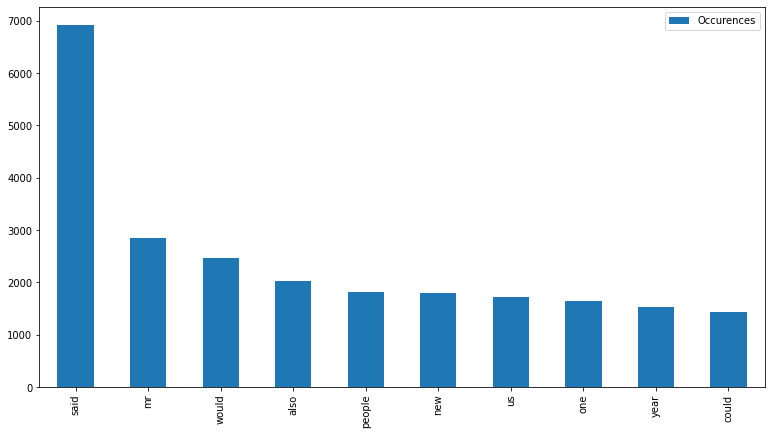

In [ ]:
top_words.plot(kind='bar', figsize = (13,7))

In [ ]:
n_features

33892

### 2.2 Data Stemming

In [ ]:
def stemming(text, stemmer):
  text = [stemmer.stem(word) for word in text.split()]
  return ' '.join(text)

In [ ]:
sb_stemmer = SnowballStemmer('english')

In [ ]:
data['Description'] = data['Description'].apply(stemming, stemmer=sb_stemmer)

In [ ]:
top_words, n_features = top_n_words_features(vectorizer, data['Description'], 10)

<AxesSubplot:>

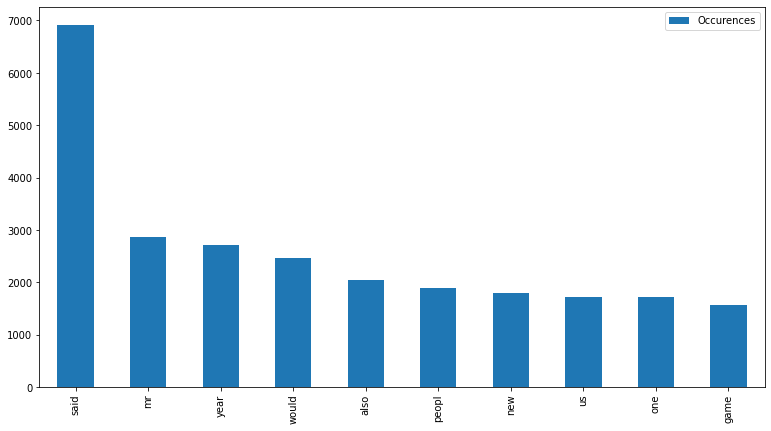

In [ ]:
top_words.plot(kind='bar', figsize = (13,7))

In [ ]:
n_features

24046

### 2.3 Removing further stopwords and Tokenising

In [ ]:
stop_words.extend(['said', 'mr', 'would', 'also', 'could'])
data['Description'] = data['Description'].apply(remove_stopwords, stop_words = stop_words)

In [ ]:
tokeniser = CountVectorizer(max_df = 0.95, min_df = 5)
tokenised_data = tokeniser.fit_transform(data['Description'])

In [ ]:
top_words, n_features = top_n_words_features(tokeniser, data['Description'], 10)

<AxesSubplot:>

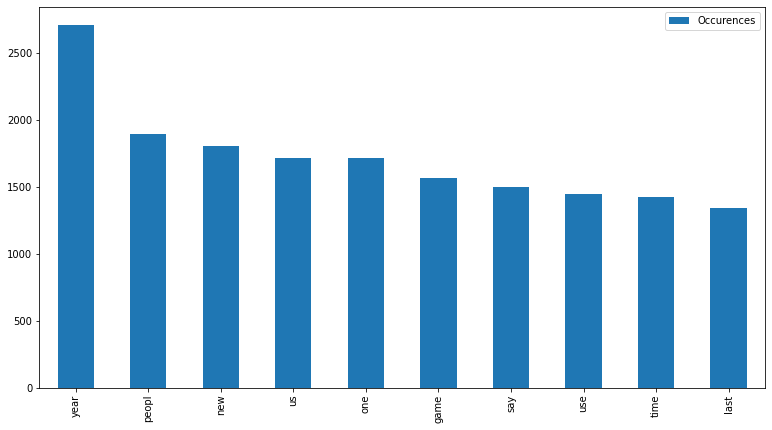

In [ ]:
top_words.plot(kind = 'bar', figsize = (13,7))

In [ ]:
n_features

6645

## 3. LDA

### 3.1 LDA Model Fitting with Hyperparameter tuning

In [ ]:
%%time
lda = LatentDirichletAllocation()
grid_params = {'n_components' : list(range(5,7))}
lda_model = GridSearchCV(lda, param_grid = grid_params)
lda_model.fit(tokenised_data)

CPU times: user 2min 13s, sys: 682 ms, total: 2min 14s
Wall time: 2min 17s


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [5, 6]})

In [ ]:
best_lda_model = lda_model.best_estimator_
print("Parameters on Best LDA Model" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on data", best_lda_model.perplexity(tokenised_data))

Parameters on Best LDA Model {'n_components': 5}
Best log likelihood Score for the LDA model -717268.8047909426
LDA model Perplexity on data 1953.1953326159287


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [ ]:
lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, tokenised_data, tokeniser, mds='tsne')
lda_panel

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      13.470154  56.014492       1        1  26.284025
2      62.617260 -14.121579       2        1  23.830419
1      13.198150 -11.483940       3        1  20.577509
0      58.884434  36.739826       4        1  20.421170
4     -23.795902  21.091379       5        1   8.886877, topic_info=        Term         Freq        Total Category  logprob  loglift
2620    game  1528.000000  1528.000000  Default  30.0000  30.0000
2416    film  1008.000000  1008.000000  Default  29.0000  29.0000
2730  govern  1204.000000  1204.000000  Default  28.0000  28.0000
5181    sale   661.000000   661.000000  Default  27.0000  27.0000
3464  labour   731.000000   731.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
2709      go   113.400374  1142.009163   Topic5  -5.7729   0.1110
3121  includ   107.757997   795.619470   Topic5  -5.8240   0.4214
6569    work   110.066493  1007.968263   Topic5  -5.8028   0.2060
6297     use   110.357232  1420.381922   Topic5  -5.8001  -0.1344
4467   peopl   109.644371  1864.166867   Topic5  -5.8066  -0.4127

[405 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
164       1  0.122224     2004
164       2  0.031429     2004
164       3  0.162384     2004
164       4  0.550010     2004
164       5  0.134447     2004
...     ...       ...      ...
6614      2  0.109464     year
6614      3  0.144447     year
6614      4  0.359237     year
6614      5  0.105326     year
6633      2  0.989337  yugansk

[896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1, 5])